<a href="https://colab.research.google.com/github/IagoMagalhaes23/Machine-Learning-com-Frameworks/blob/main/Rede_CNN_Classificador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import zipfile
 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import keras.layers as layers
 
 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive #Importação da biblioteca Drive
drive.mount('/content/gdrive') #Cria uma pasta gdrive com arquivos do drive

Mounted at /content/gdrive


In [ ]:
path = '/content/Data/'
#base_imgs = 'Material/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset'
base_imgs = '/content/gdrive/My Drive/archive.zip'
zip_object = zipfile.ZipFile(file=base_imgs, mode='r')
zip_object.extractall('./')
zip_object.close

# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/COVID19/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/COVID19/'

# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpg')

test_normal_cases = glob.glob(test_normal_dir + '*jpg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpg')

# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]

# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])

# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)

# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])

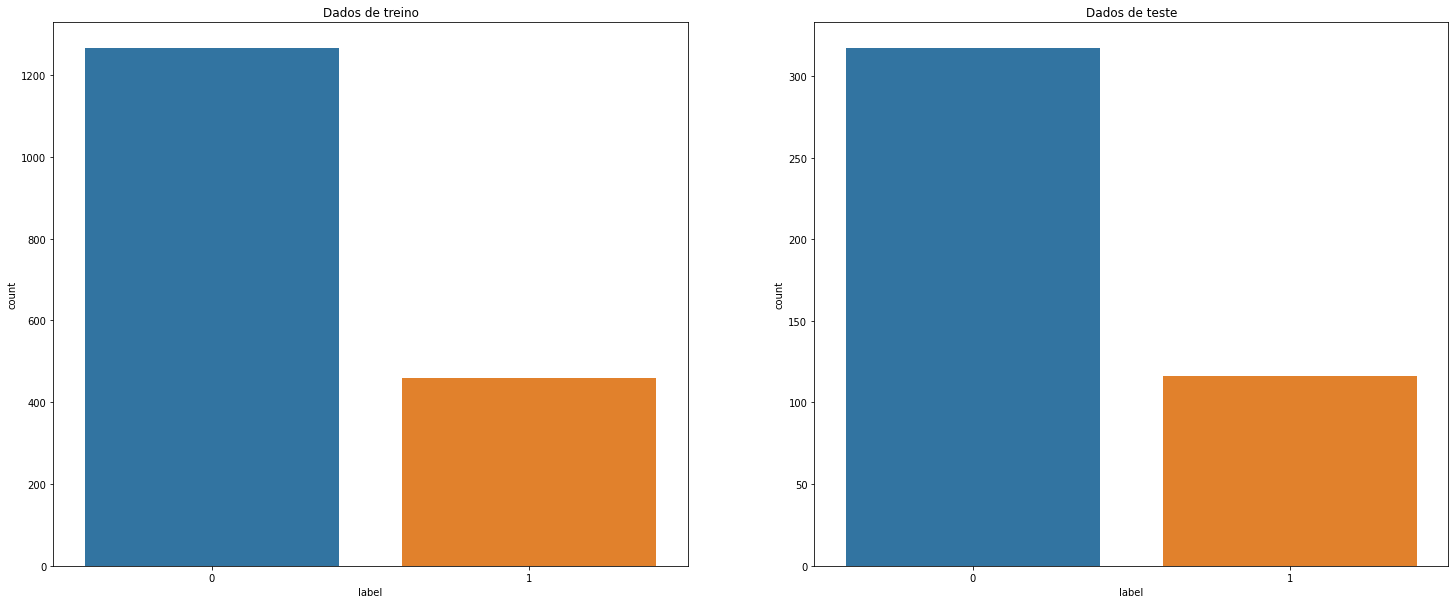

In [ ]:
plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
sns.countplot(train_df['label'])
plt.title('Dados de treino')

plt.subplot(1,2,2)
sns.countplot(test_df['label'])
plt.title('Dados de teste')

plt.show()

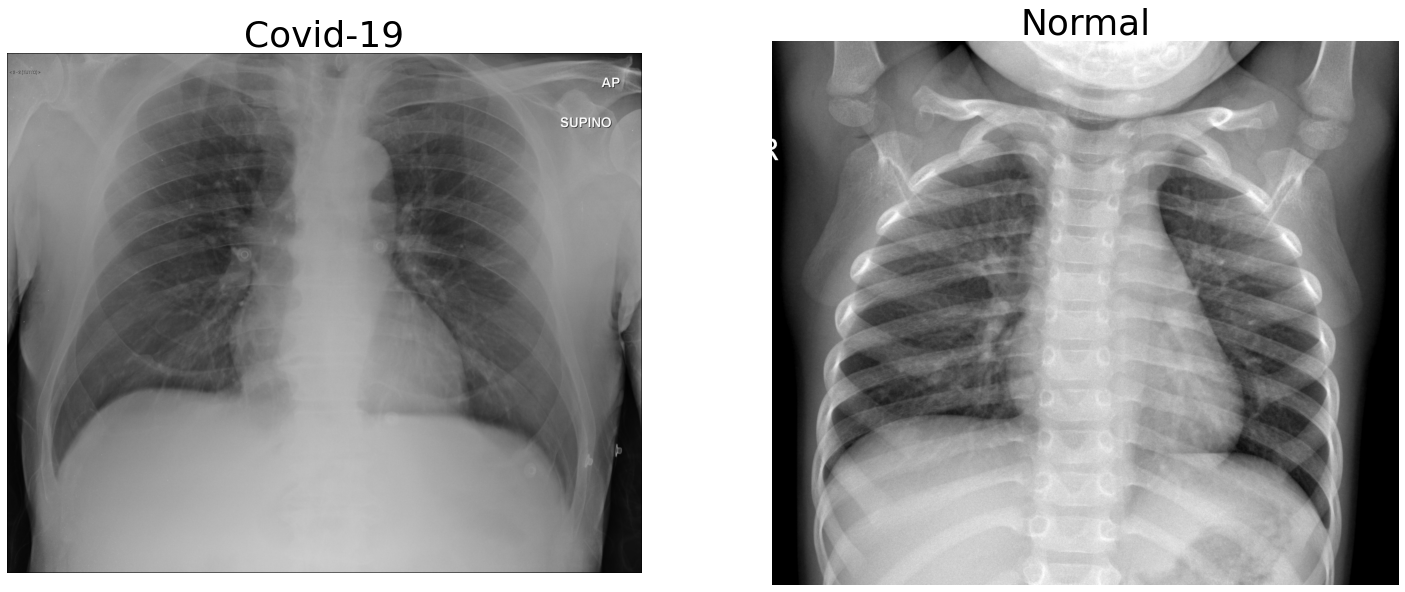

In [ ]:
plt.figure(figsize=(25,10))
for i,img_path in enumerate(train_df[train_df['label'] == 1][3:4]['image']):
    plt.subplot(1,2,1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Covid-19', fontSize=36)
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][3:4]['image']):
    plt.subplot(1,2,2)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal', fontSize=36)

In [ ]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = cv2.GaussianBlur(img, ( 3, 3), 0)
    img = np.reshape(img, (196,196,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

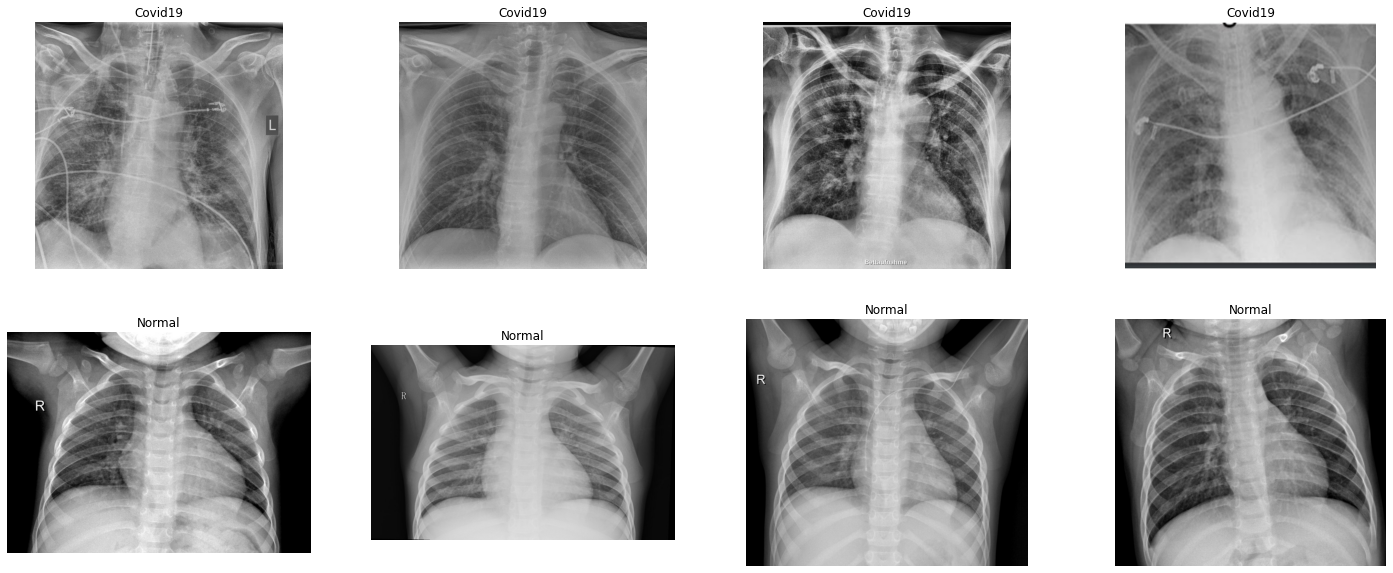

In [ ]:
plt.figure(figsize=(25,10))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Covid19')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

In [ ]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))

Train data shape: (1726, 196, 196, 1), Labels shape: (1726,)
Test data shape: (433, 196, 196, 1), Labels shape: (433,)


In [ ]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
#Modelo de rede copiado do Kaggle
'''
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(196, 196, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=6)

history = model.fit(datagen.flow(X_train,y_train, batch_size=4), validation_data=(X_test, y_test), epochs = 100, verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})
model.summary()
'''

#Modelo de rede LeNet-5
'''
model = Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=128, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=2, activation = 'softmax'))

optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=6)

history = model.fit(datagen.flow(X_train,y_train, batch_size=4), validation_data=(X_test, y_test), epochs = 100, verbose = 1, callbacks=[callback])
model.summary()
'''

#Modelo de rede AlexNet
'''
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), padding="same", activation="relu", input_shape=(196,196,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu"))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding="same", activation="relu"))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units=1024,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=1024,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=2,activation="softmax"))

optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=6)

history = model.fit(datagen.flow(X_train,y_train, batch_size=4), validation_data=(X_test, y_test), epochs = 100, verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})
model.summary()
'''

#Modelo de rede desenvolvido/alterado

#Cria um callback para salvar o melhor modelo a cada "epoch" de treinamento completada: 
mc = ModelCheckpoint(monitor='val_loss', filepath='classificador_raiox.hdf5', save_best_only=True, verbose=1)

model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(196, 196, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=6)

history = model.fit(datagen.flow(X_train,y_train, batch_size=4), validation_data=(X_test, y_test), epochs = 100, verbose = 1, callbacks=[mc, callback], class_weight={0:6.0, 1:0.5})
model.summary()
#Carrega os pesos do melhor modelo
model = keras.models.load_model('classificador_raiox.hdf5')

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
432/432 [==============================] - 41s 20ms/step - loss: 0.5785 - accuracy: 0.7364 - val_loss: 0.2009 - val_accuracy: 0.9423

Epoch 00001: val_loss improved from inf to 0.20094, saving model to classificador_raiox.hdf5
Epoch 2/100
432/432 [==============================] - 7s 16ms/step - loss: 0.2298 - accuracy: 0.8754 - val_loss: 0.0704 - val_accuracy: 0.9792

Epoch 00002: val_loss improved from 0.20094 to 0.07043, saving model to classificador_raiox.hdf5
Epoch 3/100
432/432 [==============================] - 7s 17ms/step - loss: 0.2063 - accuracy: 0.8917 - val_loss: 0.0871 - val_accuracy: 0.9769

Epoch 00003: val_loss did not improve from 0.07043
Epoch 4/100
432/432 [==============================] - 7s 16ms/step - loss: 0.1709 - accuracy: 0.9154 - val_loss: 0.3481 - val_accuracy: 0.8199

Epoch 00004: val_loss did not improve fr

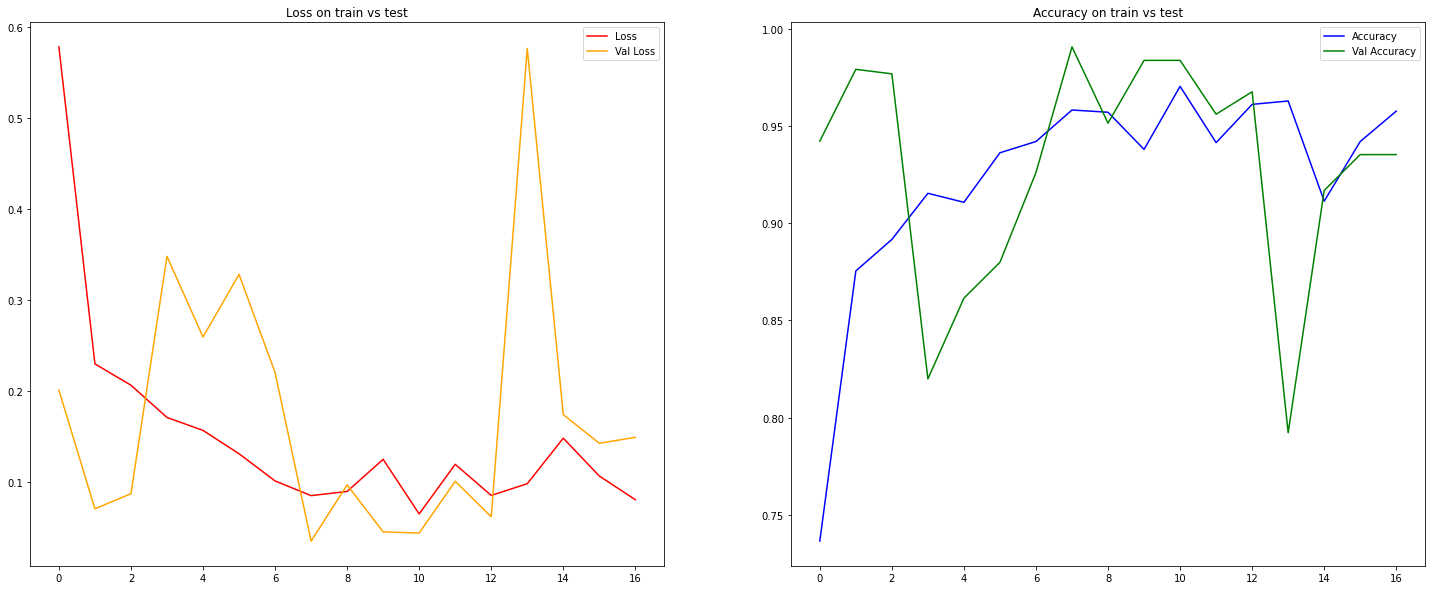

In [ ]:
plt.figure(figsize=(25,10))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

In [ ]:
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

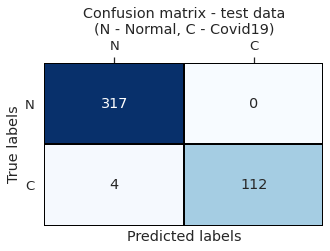

Classification report on test data
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       317
           1       1.00      0.97      0.98       116

    accuracy                           0.99       433
   macro avg       0.99      0.98      0.99       433
weighted avg       0.99      0.99      0.99       433



In [ ]:
# calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['N', 'C'], yticklabels=['N', 'C'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(N - Normal, C - Covid19)')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)

[[0.15602705 0.8439729 ]]
1
Pred=None label=Covid-19
[[0.9988662  0.00113385]]
0
Pred=None label=Saudável
[[0.01558376 0.9844162 ]]
1
Pred=None label=Covid-19
[[9.9987566e-01 1.2432243e-04]]
0
Pred=None label=Saudável
[[9.9999654e-01 3.4693267e-06]]
0
Pred=None label=Saudável
[[9.9950123e-01 4.9878616e-04]]
0
Pred=None label=Saudável
[[0.78614056 0.21385945]]
0
Pred=None label=Covid-19
[[9.9999416e-01 5.8163459e-06]]
0
Pred=None label=Saudável
[[0.00681577 0.99318427]]
1
Pred=None label=Covid-19
[[0.00859148 0.9914085 ]]
1
Pred=None label=Covid-19


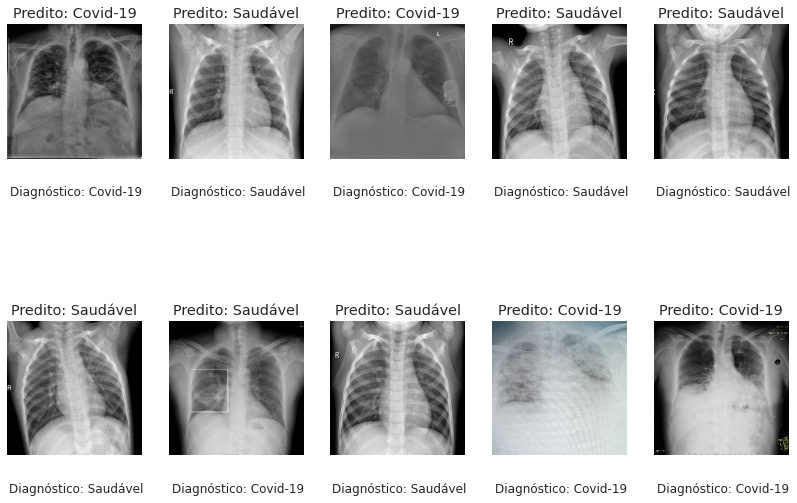

In [ ]:
from keras.models import load_model
path_imgs = '/content/gdrive/My Drive/Imagens de validação/'

# find all files, our files has extension jpeg
validacao = glob.glob(path_imgs + '*jpg')
rn.shuffle(validacao)

# Carrega os pesos do modelo
model = load_model('classificador_raiox.hdf5')

def prepararImagem(imagem):
    test_image = image.img_to_array(imagem)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = test_image/255.0
    return test_image

def mostraCateg(resultado):
    if (resultado < 1).all():
      categs = "Saudável"
      return categs
    else:
      categs = "Covid-19"
      return categs

def mostraCateg2(resultado):
    categs = ["Saudável", "Covid-19"]
    for idx, val in enumerate(resultado[0]):
        if val == 1:
            return categs[idx]
    
def getLabel(nome):
  rotulos = []
  if '_0.jpg' in nome: 
    rotulos.append(0)
  else:
    rotulos.append(1)
  return keras.utils.to_categorical(rotulos, 2)

i = 1
fig=plt.figure(figsize=(14, 10))

for nome in validacao:
    im = cv2.imread(nome)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    #gray = cv2.GaussianBlur(gray, ( 3, 3), 0)
    imres = cv2.resize(gray, (196, 196), interpolation=cv2.INTER_CUBIC)
    imres2 = cv2.resize(im, (196, 196), interpolation=cv2.INTER_CUBIC)
    dados = prepararImagem(imres)
    fig.add_subplot(2, 5, i)
    
    plt.imshow(imres2)
    plt.axis('off')
    ret = model.predict(dados, batch_size=1)
    pred_classes = np.argmax(ret)
    print(ret)
    print(pred_classes)
    label = getLabel(nome)

    plt.text(100, 250, 'Diagnóstico: '+mostraCateg2(label)+'',
             fontsize=12, ha='center')
   
    plt.title('Predito: '+mostraCateg(pred_classes))
    print('Pred='+str(mostraCateg2(ret))+" label="+str(mostraCateg2(label)))
    i = i + 1
plt.show()